In [106]:
import pandas as pd
import datetime as dt
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter

sns.set()
my_palette = sns.color_palette("husl")
my_palette.pop(1)
sns.set_palette(sns.color_palette(my_palette))

## Data Exploration

In [94]:
data = pd.read_csv("data/452 01-04-20.csv")
print(data.shape)
data.head()

(10239, 6)


,arrived,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
0,True,Ladbroke Road,2020-04-01 09:57:41,20198_490000167A_2020-04-01_out_0,2020-04-01 09:52:33,out
1,True,Silverthorne Road,2020-03-11 09:52:37,20191_490012162E_2020-03-11_out_0,2020-03-11 09:52:12,out
2,True,Knightsbridge Station,2020-03-30 05:43:05,20278_490G00130K1_2020-03-30_out_0,2020-03-30 05:20:12,out
3,True,Notting Hill Gate Station,2020-03-11 14:27:25,20190_490000167G_2020-03-11_out_0,2020-03-11 14:27:10,out
4,True,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in


In [95]:
data = data.drop(columns = "arrived")
print(data['bus_stop_name'].unique())
print(len(data['bus_stop_name'].unique()))

['Ladbroke Road' 'Silverthorne Road' 'Knightsbridge Station'
 'Notting Hill Gate Station' 'Battersea Park Station'
 'Kilburn Lane / Harrow Road' 'Sopwith Way' "Ladbroke Grove Sainsbury's"
 'Queenstown Road / Wandsworth Road' 'Sheffield Terrace'
 'Sloane Street / Knightsbridge Station' 'Battersea Park / Chelsea Gate'
 'Wandsworth Road Station' 'Royal Hospital Road' 'Barlby Road'
 'Vauxhall Bus Station' 'Larkhall Park' 'Prairie Street' 'Lister Hospital'
 'Banister Road' 'Chesterton Road' 'Stanley Gardens'
 'Prince Of Wales Gate' 'Lansdowne Green'
 'Sloane Square Stn  / Lower Sloane St' 'Kensington Palace'
 'Portobello and Golborne Market' 'St Charles Square' 'Union Road'
 'The Chase' 'Queenstown Road Station' 'Westbury Street'
 'Kensal Rise Station' 'Kensal House'
 'York House Place / Kensington High St' 'Knightsbridge Barracks'
 'Exhibition Road' 'Blenheim Crescent' 'St Rule Street' 'Wilcox Road'
 'Station Terrace' 'Royal Hospital Chelsea' 'Palace Gate'
 'Rutland Gardens' 'Sloane Street

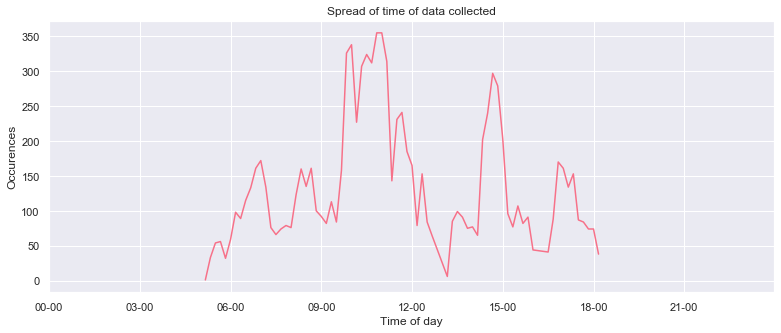

In [102]:
hour_min = [x[11:15] + '0' for x in data['expected_arrival']]
for_aggr = data.assign(hour_min = hour_min)
for_aggr = for_aggr.groupby('hour_min').count().reset_index()

arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(arrival_times, for_aggr['bus_stop_name'])
ax.set_title("Spread of time of data collected")
ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
date_form = DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel("Time of day")
ax.set_ylabel("Occurences")
plt.show()

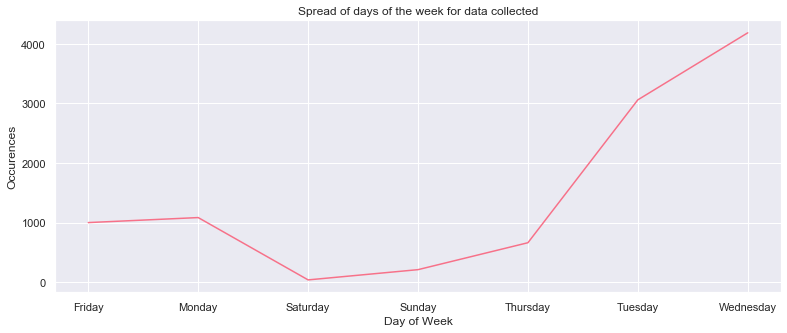

In [110]:
day_of_week = [x[:10] for x in data['expected_arrival']]
day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
for_aggr = data.assign(day_of_week = day_of_week)
for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
ax.set_title("Spread of days of the week for data collected")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Occurences")
plt.show()

### Try to see if I can get the average time taken for a bus to travel between "Vauxhall Bus Station" and "Covent Garden Market East Side" (inbound)

In [114]:
vauxhall = data.loc[(data['bus_stop_name'] == 'Vauxhall Bus Station') & (data['direction'] == 'in')]
print(vauxhall.shape)
vauxhall.head()

(112, 5)


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
18,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
31,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
125,Vauxhall Bus Station,2020-03-27 09:24:34,20194_490000247G1_2020-03-27_in_0,2020-03-27 09:03:54,in
222,Vauxhall Bus Station,2020-03-18 18:05:21,20193_490000247G1_2020-03-18_in_0,2020-03-18 18:05:12,in
305,Vauxhall Bus Station,2020-03-11 10:37:58,20190_490000247G1_2020-03-11_in_0,2020-03-11 10:38:22,in


In [115]:
covent_garden = data.loc[(data['bus_stop_name'] == 'Covent Garden Market East Side') & (data['direction'] == 'in')]
print(covent_garden.shape)
covent_garden.head()

(113, 5)


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
136,Covent Garden Market East Side,2020-03-03 14:29:47,20280_490005678X_2020-03-03_in_0,2020-03-03 14:29:42,in
161,Covent Garden Market East Side,2020-03-31 07:33:40,20202_490005678X_2020-03-31_in_0,2020-03-31 07:33:11,in
248,Covent Garden Market East Side,2020-03-25 15:23:55,20312_490005678X_2020-03-25_in_0,2020-03-25 15:21:08,in
499,Covent Garden Market East Side,2020-03-30 05:42:48,20275_490005678X_2020-03-30_in_0,2020-03-30 05:20:12,in
586,Covent Garden Market East Side,2020-03-18 17:30:03,20197_490005678X_2020-03-18_in_0,2020-03-18 17:25:33,in


In [116]:
vehicle_id = '20280_490005678X_2020-03-03_in_0'
[bus_id, stop_id, date, direction, num_trip] = vehicle_id.split('_')

bus = covent_garden.loc[covent_garden['vehicle_id'].str.startswith(bus_id, na=False)]
bus = bus.drop(columns = ["direction", "bus_stop_name", "time_of_req"])
print(bus)
same_bus = vauxhall.loc[vauxhall['vehicle_id'].str.startswith(bus_id, na=False)]
same_bus = same_bus.drop(columns = ["direction", "bus_stop_name", "time_of_req"])
print(same_bus)

          expected_arrival                        vehicle_id
136    2020-03-03 14:29:47  20280_490005678X_2020-03-03_in_0
8313   2020-03-10 11:14:59  20280_490005678X_2020-03-10_in_0
10203  2020-03-11 10:58:18  20280_490005678X_2020-03-11_in_0
         expected_arrival                         vehicle_id
6066  2020-03-10 11:17:41  20280_490000247G1_2020-03-10_in_0
8450  2020-03-11 10:59:41  20280_490000247G1_2020-03-11_in_0
8555  2020-03-03 14:31:38  20280_490000247G1_2020-03-03_in_0
